In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam

import seaborn as sns
import random
import csv

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler


In [2]:
import numpy as np
import pandas as pd
import pmdarima as pm
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection
from tensorflow.keras.layers import LSTM

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from matplotlib import pyplot as plt

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, PReLU
from keras_tuner.tuners import RandomSearch

from sklearn.metrics import mean_absolute_percentage_error

Using TensorFlow backend


In [4]:
df=pd.read_csv('icecream_sales_date 2009-2022.csv', index_col='date', parse_dates=True,encoding="utf-8")
df.head()

,sales,tokyo_temperature,holiday,Unnamed: 4,temperature_difference_2009_2018,temperature_difference_2019_2021,Unnamed: 7,2009,2010,2011,...,2015,2016,2017,2018,2019,2020,2021,2022,AVERAGE2009-2018,AVERAGE2019-2021
date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,17.59,10.6,1,NaN,0.521429,0.033333,1.0,10.2,11.0,9.1,...,10.4,10.6,10.8,9.4,10.3,11.1,10.3,9.4,10.078571,10.566667
2009-01-02,23.83,11.6,1,NaN,1.521429,1.033333,2.0,11.5,9.9,11.2,...,10.4,12.2,12.1,10.1,11.6,13.3,14.0,10.5,11.142857,12.966667
2009-01-03,22.94,10.7,1,NaN,0.621429,0.133333,3.0,13.7,13.2,12.3,...,15.5,14.9,13.4,16.9,15.4,16.0,17.9,16.6,14.942857,16.433333
2009-01-04,17.14,11.1,1,NaN,1.021429,0.533333,4.0,20.2,16.6,18.9,...,19.3,20.3,19.9,22.1,19.0,18.2,20.6,20.2,19.471429,19.266667
2009-01-05,10.32,11.8,0,NaN,1.721429,1.233333,5.0,23.6,23.0,22.2,...,26.4,25.2,25.1,24.6,25.3,24.0,24.1,23.5,24.242857,24.466667


In [5]:
#df_train=df["2009-01-01":"2018-12-31"]
#df_test=df["2019-01-01":"2019-12-31"]
df_19=df["2009-01-01":"2019-12-31"]

In [6]:
sales=df_19["sales"]
sales

date
2009-01-01    17.59
2009-01-02    23.83
2009-01-03    22.94
2009-01-04    17.14
2009-01-05    10.32
              ...  
2019-12-27    18.54
2019-12-28    24.99
2019-12-29    33.16
2019-12-30    25.73
2019-12-31    33.84
Name: sales, Length: 4015, dtype: float64

In [7]:
sales_train=sales["2009-01-01":"2018-12-31"]
sales_test=sales["2019-01-01":"2019-12-31"]

In [8]:
sales_np = np.array(sales, dtype=float)
sales_np

array([17.59, 23.83, 22.94, ..., 33.16, 25.73, 33.84])

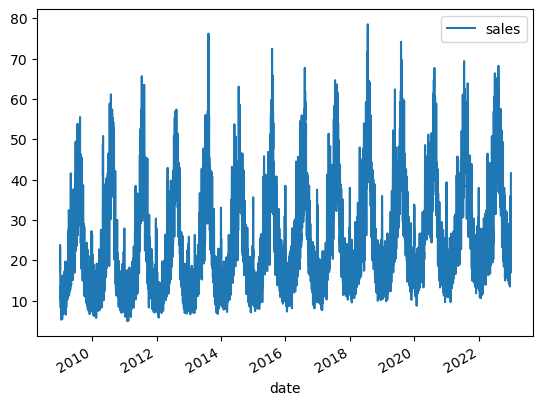

In [9]:
saless=df["sales"]
saless.plot()
#ヨコ軸のラベル
plt.legend()                                       #凡例表示
plt.show()

In [10]:
series=sales_np
series.shape

(4015,)

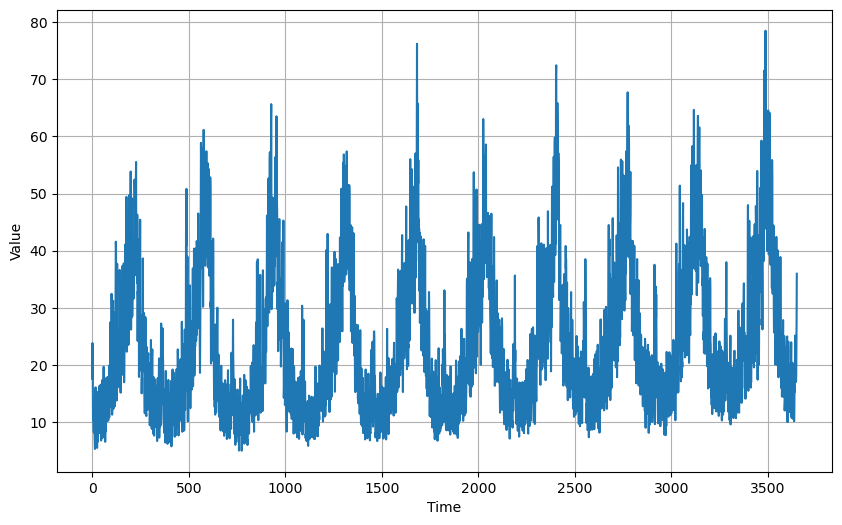

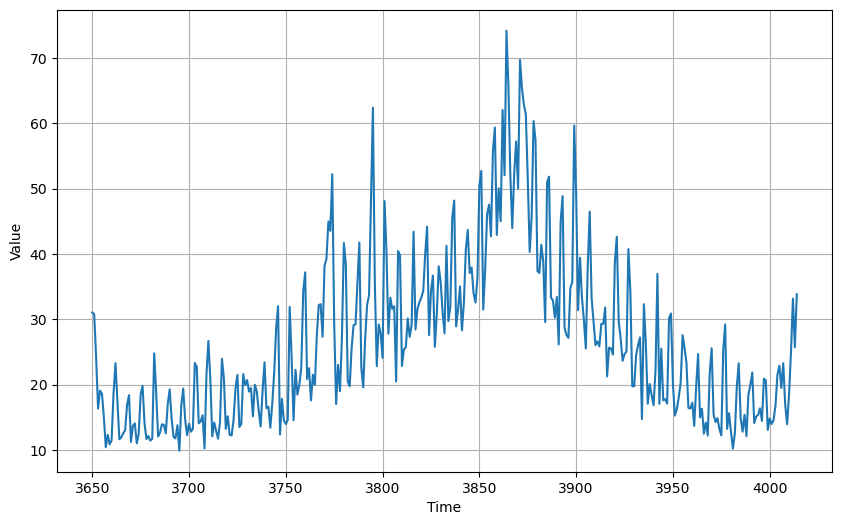

In [11]:
year=10
split_time = 365*year
time = np.arange(365*year+365, dtype="float32")

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


window_size = 32
batch_size = 256
shuffle_buffer_size = 4000

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train) # 学習セット
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid) # 検証セット
plt.show()

In [12]:
def windowing(df, window_size):
  x = []
  y = []

  for i in range(len(df) - window_size):
    x_result = df[i:i+window_size].to_list()
    x.append(x_result)
    y_result = df[i+window_size]
    y.append(y_result)

  return np.array(x), np.array(y)

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [14]:
x_train

array([17.59, 23.83, 22.94, ..., 22.93, 27.97, 35.97])

In [15]:
sales

date
2009-01-01    17.59
2009-01-02    23.83
2009-01-03    22.94
2009-01-04    17.14
2009-01-05    10.32
              ...  
2019-12-27    18.54
2019-12-28    24.99
2019-12-29    33.16
2019-12-30    25.73
2019-12-31    33.84
Name: sales, Length: 4015, dtype: float64

In [16]:
window_size = 20

x_train_lstm, y_train_lstm = windowing(sales_train, window_size)
x_test_lstm, y_test_lstm = windowing(sales_test,window_size)

In [17]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Bidirectional
from tensorflow.keras.layers import Conv1D

# build lstm model
lstm_model = Sequential()
#lstm_model.add(tf.keras.layers.Bidirectional(LSTM(100, input_shape=(window_size, 1))))
#lstm_model.add(Dense(10))
lstm_model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]))
lstm_model.add(LSTM(100, activation='relu', input_shape=(window_size,)))
#lstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
#lstm_model.add(Bidirectional(LSTM(32)))
#lstm_model.add(Dense(1))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
#lstm_model.add(LSTM(100, input_shape=[window_size, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.5))
#lstm_model.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.5, activation='relu')) 
#lstm_model.add(Dense(1))
#lstm_model.summary()

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, 
        verbose=1, mode='auto', restore_best_weights=True)

In [19]:
cp = ModelCheckpoint('model/', save_best_only=True)
lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())

In [20]:
# train lstm model
history = lstm_model.fit(tf.expand_dims(x_train_lstm, axis=-1), y_train_lstm, validation_data=(x_test_lstm, y_test_lstm), epochs=50, batch_size=32,verbose=1, callbacks=[cp])

Epoch 1/50
110/114 [===========================>..] - ETA: 0s - loss: 84.3982 - root_mean_squared_error: 9.1868

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 6s 33ms/step - loss: 83.3350 - root_mean_squared_error: 9.1288 - val_loss: 50.4011 - val_root_mean_squared_error: 7.0994
Epoch 2/50
112/114 [============================>.] - ETA: 0s - loss: 39.1935 - root_mean_squared_error: 6.2605

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 3s 28ms/step - loss: 39.2110 - root_mean_squared_error: 6.2619 - val_loss: 41.3697 - val_root_mean_squared_error: 6.4319
Epoch 3/50
113/114 [============================>.] - ETA: 0s - loss: 33.0513 - root_mean_squared_error: 5.7490

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 3s 30ms/step - loss: 33.0981 - root_mean_squared_error: 5.7531 - val_loss: 36.5370 - val_root_mean_squared_error: 6.0446
Epoch 4/50
114/114 [==============================] - ETA: 0s - loss: 28.1812 - root_mean_squared_error: 5.3086

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 3s 29ms/step - loss: 28.1812 - root_mean_squared_error: 5.3086 - val_loss: 34.7405 - val_root_mean_squared_error: 5.8941
Epoch 5/50
114/114 [==============================] - 2s 13ms/step - loss: 27.4034 - root_mean_squared_error: 5.2348 - val_loss: 34.9023 - val_root_mean_squared_error: 5.9078
Epoch 6/50
110/114 [===========================>..] - ETA: 0s - loss: 25.6358 - root_mean_squared_error: 5.0632

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 3s 29ms/step - loss: 25.6839 - root_mean_squared_error: 5.0679 - val_loss: 33.3703 - val_root_mean_squared_error: 5.7767
Epoch 7/50
111/114 [============================>.] - ETA: 0s - loss: 25.6406 - root_mean_squared_error: 5.0637

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 3s 29ms/step - loss: 25.6837 - root_mean_squared_error: 5.0679 - val_loss: 32.0499 - val_root_mean_squared_error: 5.6613
Epoch 8/50
114/114 [==============================] - 1s 13ms/step - loss: 24.4851 - root_mean_squared_error: 4.9482 - val_loss: 32.2670 - val_root_mean_squared_error: 5.6804
Epoch 9/50
114/114 [==============================] - ETA: 0s - loss: 24.2835 - root_mean_squared_error: 4.9278

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 4s 31ms/step - loss: 24.2835 - root_mean_squared_error: 4.9278 - val_loss: 30.7287 - val_root_mean_squared_error: 5.5433
Epoch 10/50
114/114 [==============================] - 2s 13ms/step - loss: 23.1224 - root_mean_squared_error: 4.8086 - val_loss: 32.8705 - val_root_mean_squared_error: 5.7333
Epoch 11/50
112/114 [============================>.] - ETA: 0s - loss: 23.3140 - root_mean_squared_error: 4.8285

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 3s 29ms/step - loss: 23.2773 - root_mean_squared_error: 4.8247 - val_loss: 30.2525 - val_root_mean_squared_error: 5.5002
Epoch 12/50
114/114 [==============================] - 2s 14ms/step - loss: 22.5417 - root_mean_squared_error: 4.7478 - val_loss: 30.4852 - val_root_mean_squared_error: 5.5213
Epoch 13/50
110/114 [===========================>..] - ETA: 0s - loss: 22.1260 - root_mean_squared_error: 4.7038

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 3s 29ms/step - loss: 22.1091 - root_mean_squared_error: 4.7020 - val_loss: 28.4358 - val_root_mean_squared_error: 5.3325
Epoch 14/50
114/114 [==============================] - 1s 11ms/step - loss: 21.4206 - root_mean_squared_error: 4.6282 - val_loss: 29.6390 - val_root_mean_squared_error: 5.4442
Epoch 15/50
114/114 [==============================] - 1s 12ms/step - loss: 21.7553 - root_mean_squared_error: 4.6643 - val_loss: 28.4707 - val_root_mean_squared_error: 5.3358
Epoch 16/50
114/114 [==============================] - 2s 13ms/step - loss: 20.9060 - root_mean_squared_error: 4.5723 - val_loss: 29.1785 - val_root_mean_squared_error: 5.4017
Epoch 17/50
114/114 [==============================] - 2s 14ms/step - loss: 21.4248 - root_mean_squared_error: 4.6287 - val_loss: 31.2628 - val_root_mean_squared_error: 5.5913
Epoch 18/50
114/114 [==============================] - 2s 14ms/step - loss: 20.7466 - root_mean_squared_error: 4.5548 - val_loss: 28

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 4s 33ms/step - loss: 20.4003 - root_mean_squared_error: 4.5167 - val_loss: 27.7883 - val_root_mean_squared_error: 5.2715
Epoch 23/50
114/114 [==============================] - 1s 12ms/step - loss: 19.8607 - root_mean_squared_error: 4.4565 - val_loss: 30.2740 - val_root_mean_squared_error: 5.5022
Epoch 24/50
113/114 [============================>.] - ETA: 0s - loss: 19.7594 - root_mean_squared_error: 4.4452

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


114/114 [==============================] - 3s 29ms/step - loss: 19.7880 - root_mean_squared_error: 4.4484 - val_loss: 27.3485 - val_root_mean_squared_error: 5.2296
Epoch 25/50
114/114 [==============================] - 2s 14ms/step - loss: 19.9345 - root_mean_squared_error: 4.4648 - val_loss: 28.6151 - val_root_mean_squared_error: 5.3493
Epoch 26/50
114/114 [==============================] - 2s 14ms/step - loss: 19.6307 - root_mean_squared_error: 4.4307 - val_loss: 29.0586 - val_root_mean_squared_error: 5.3906
Epoch 27/50
114/114 [==============================] - 2s 14ms/step - loss: 19.2022 - root_mean_squared_error: 4.3820 - val_loss: 29.0619 - val_root_mean_squared_error: 5.3909
Epoch 28/50
114/114 [==============================] - 2s 14ms/step - loss: 19.2297 - root_mean_squared_error: 4.3852 - val_loss: 28.3769 - val_root_mean_squared_error: 5.3270
Epoch 29/50
114/114 [==============================] - 2s 15ms/step - loss: 19.1070 - root_mean_squared_error: 4.3712 - val_loss: 28

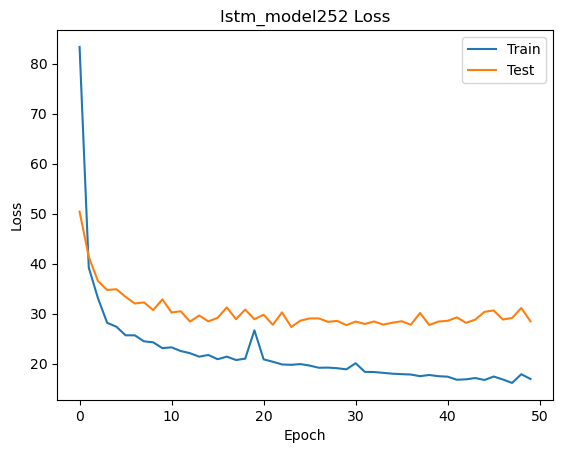

In [21]:
# plot train and test loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('lstm_model252 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [22]:
loss_df = pd.DataFrame({'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss = pd.DataFrame({'min': loss_df.min(), 'max': loss_df.max()})
loss
print(loss_df.min())

loss        16.167688
val_loss    27.348537
dtype: float64


In [23]:
# load lstm model
from tensorflow.keras.models import load_model
lstm_model = load_model('model/')

In [24]:
train_predictions = lstm_model.predict(x_train_lstm).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train_lstm})
train_results

114/114 [==============================] - 1s 5ms/step


,Train Predictions,Actuals
0,9.898503,7.12
1,7.951301,8.35
2,9.338490,10.68
3,15.271304,14.25
4,13.876727,15.30
...,...,...
3625,15.945718,17.04
3626,17.600531,18.28
3627,23.290304,22.93
3628,27.366636,27.97


In [25]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [26]:
forecast = model_forecast(lstm_model, series[split_time - window_size:-1], window_size)[:,0]

12/12 [==============================] - 1s 116ms/step


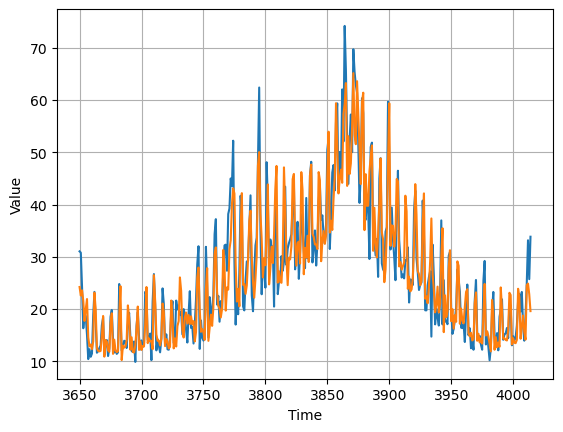

In [27]:
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [28]:
print('RMSE : ',np.sqrt(((x_valid - forecast)**2).mean()))
mae=mean_absolute_error(x_valid, forecast)
print('MAE : ',mae)

RMSE :  5.1518424952245425
MAE :  3.701725854011431
